In [52]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [53]:
data=pd.read_csv('montreal2017.csv')
data.replace('InVld',np.nan,inplace=True)
data.replace('<Samp',np.nan,inplace=True)
data.replace('Down',np.nan,inplace=True)
data.replace('Calib',np.nan,inplace=True)
data.replace('NoData',np.nan,inplace=True)
dataset=data.iloc[:,4:].copy()

In [33]:
dataset=dataset.astype(np.float32)

In [34]:
dataset.iat[0,7]

23.3

In [36]:
for i in range(len(dataset)):
    for j in range(len(dataset.columns)):
        if np.isnan(dataset.iat[i,j]):
            if i==0:
                dataset.iloc[i,j]=dataset.iat[i+1,j]
            elif i==len(data)-1:
                dataset.iloc[i,j]=dataset.iat[i-1,j]
            else:
                dataset.iloc[i,j]=np.nanmean([dataset.iat[i-1,j],dataset.iat[i+1,j]])

In [37]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(dataset) 
dataset.loc[:,:] = scaled_values

In [38]:
data_set=np.asarray(dataset,dtype=np.float32)
seq_len = 30 + 1
x=len(data_set)-seq_len
sequences = [data_set[t:t+seq_len] for t in range(x)]
seq=torch.FloatTensor(sequences)

In [39]:
seq.shape

torch.Size([8729, 31, 12])

In [42]:
split_row=round(0.90*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1]

In [43]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [44]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [45]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [46]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [47]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'montreal_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.02176169
Validation: Loss = 0.01108580
Epoch 2: Loss = 0.00993373
Validation: Loss = 0.00814029
Epoch 3: Loss = 0.00751851
Validation: Loss = 0.00711685
Epoch 4: Loss = 0.00653544
Validation: Loss = 0.00661080
Epoch 5: Loss = 0.00597231
Validation: Loss = 0.00625938
Epoch 6: Loss = 0.00561217
Validation: Loss = 0.00600351
Epoch 7: Loss = 0.00535219
Validation: Loss = 0.00580701
Epoch 8: Loss = 0.00515770
Validation: Loss = 0.00564661
Epoch 9: Loss = 0.00501222
Validation: Loss = 0.00549825
Epoch 10: Loss = 0.00489715
Validation: Loss = 0.00535485
Epoch 11: Loss = 0.00479864
Validation: Loss = 0.00521663
Epoch 12: Loss = 0.00471038
Validation: Loss = 0.00508870
Epoch 13: Loss = 0.00463067
Validation: Loss = 0.00497578
Epoch 14: Loss = 0.00455970
Validation: Loss = 0.00487948
Epoch 15: Loss = 0.00449824
Validation: Loss = 0.00480005
Epoch 16: Loss = 0.00444534
Validation: Loss = 0.00473615
Epoch 17: Loss = 0.00439898
Validation: Loss = 0.0046

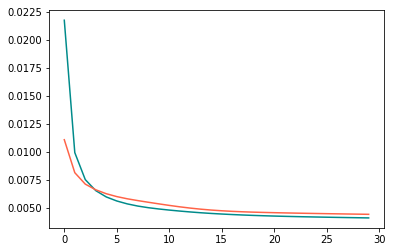

In [48]:
input_size=12
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size,num_layers)

learning_rate=0.001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
    total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]

    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [50]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
        predictions[i]=y_pred[:,-1]
    return predictions

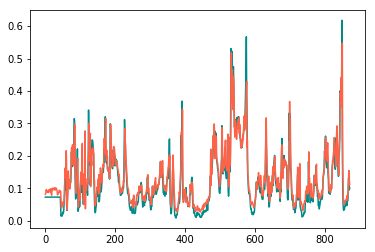

In [51]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))
plt.plot(y_valid_set[:,-1].data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()